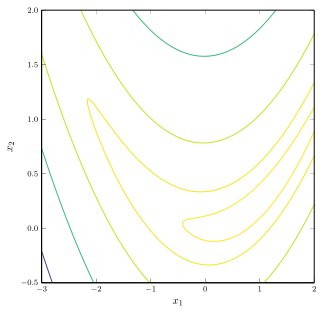

In [23]:
###################################################################################
using Plots, LaTeXStrings, Printf, LinearAlgebra, Dates
pgfplotsx() #pyplot()

# Rosenbrock function
fp(x1,x2) = (1 - x1)^2 + 5*(4x2 - x1^2)^2

x1 = -3:0.01:2
x2 = -0.5:0.01:2

pl1 = contour(x1, x2, fp, framestyle = :box,
    levels=[2,10,50,200,500], 
    c = cgrad(:viridis, rev = true), 
    ylab = L"x_2", 
    xlab = L"x_1",
    xlims = (-3,2),
    ylims = (-0.5,2),
    legend = false,
    grid = false,
    contour_labels = false,
    bins = 150,
    label = false,
    size=(450,450))

In [24]:
function bracket_minimum(f, x=0; s=1e-2, k=2.0)
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    end

    while true
        c, yc = b + s, f(b + s)
        if yc > yb
            return a < c ? (a, c) : (c, a)
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
end

using Base.MathConstants
function fibonacci_search(f, a, b, n; ϵ=0.002)
    s = (1-√5)/(1+√5)
    ρ = 1 / (φ*(1-s^(n+1))/(1-s^n))
    d = ρ*b + (1-ρ)*a
    yd = f(d)
    for i in 1 : n-1
        if i == n-1
            c = ϵ*a + (1-ϵ)*d
        else
            c = ρ*a + (1-ρ)*b
        end
        yc = f(c)
        if yc < yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
        ρ = 1 / (φ*(1-s^(n-i+1))/(1-s^(n-i)))
    end
    return a < b ? (a, b) : (b, a)
end

function line_search(f, x, d)
    objective = α -> f(x + α*d)
    a, b = bracket_minimum(objective)
    α = fibonacci_search(objective, a, b, 100)
    return x + (sum(α)/2)*d, sum(α)/2
end

line_search (generic function with 1 method)

In [25]:
mutable struct LimitedMemoryBFGS
    m
    δs
    γs
    qs
end

function init!(M::LimitedMemoryBFGS, f, ∇f, x)
    M.δs = []
    M.γs = []
    M.qs = []
    return M
end

function step!(M::LimitedMemoryBFGS, f, ∇f, x)
    δs, γs, qs, g = M.δs, M.γs, M.qs, ∇f(x)
    m = length(δs)
    if m > 0
        q = g
        for i in m : -1 : 1
            qs[i] = copy(q)
            q -= (δs[i]⋅q)/(γs[i]⋅δs[i])*γs[i]
        end
    
        z = (γs[m] .* δs[m] .* q) / (γs[m]⋅γs[m])
        for i in 1 : m
            z += δs[i]*(δs[i]⋅qs[i] - γs[i]⋅z)/(γs[i]⋅δs[i])
        end
        
        x′, α = line_search(f, x, -z)
    else
        x′, α = line_search(f, x, -g)
    end
    
    g′ = ∇f(x′)
    push!(δs, x′ - x); push!(γs, g′ - g)
    push!(qs, zeros(length(x)))

    while length(δs) > M.m
        popfirst!(δs); popfirst!(γs); popfirst!(qs)
    end
    return x′
end

step! (generic function with 1 method)

In [26]:
x0 = [-1,1.75]
points = []
push!(points, (x0))

f = x -> (1-x[1])^2 + 5*(4x[2] - x[1]^2)^2
∇f = x -> [2*(10x[1]^3 - 40x[1]*x[2] + x[1] - 1), -40*(x[1]^2 - 4x[2])]

#39 (generic function with 1 method)

In [27]:
M = LimitedMemoryBFGS(10,NaN,NaN,NaN)
init!(M, f, ∇f, x0)

LimitedMemoryBFGS(10, Any[], Any[], Any[])

In [28]:
ϵ = 10
i = 1
while ϵ > 0.0001
    x = step!(M, f, ∇f, x0)
    push!(points, (x))
    ϵ = abs(f(x) - f(x0))
    x0 = x
    println(@sprintf("Iter = %i\t x = %s\t\t f(x) = %2.4f\t Error = %2.4f", i, string(x), f(x), ϵ))
    i += 1
end

Iter = 1	 x = [-1.550082918786492, 0.6118974094072578]		 f(x) = 6.5130	 Error = 177.4870
Iter = 2	 x = [-0.284041804497408, -0.024349606290595904]		 f(x) = 1.8073	 Error = 4.7057
Iter = 3	 x = [0.3627489117207737, -0.014878592474338169]		 f(x) = 0.5887	 Error = 1.2186
Iter = 4	 x = [0.36983451561321606, 0.03533568518030501]		 f(x) = 0.3972	 Error = 0.1915
Iter = 5	 x = [0.6812688968935394, 0.09128377456267417]		 f(x) = 0.1506	 Error = 0.2466
Iter = 6	 x = [0.9953096237506964, 0.24332279902419907]		 f(x) = 0.0015	 Error = 0.1491
Iter = 7	 x = [0.9851900712166849, 0.24215967819184955]		 f(x) = 0.0002	 Error = 0.0013
Iter = 8	 x = [0.9999388800517067, 0.24999392134156462]		 f(x) = 0.0000	 Error = 0.0002
Iter = 9	 x = [1.0000053980780452, 0.2500028837750607]		 f(x) = 0.0000	 Error = 0.0000


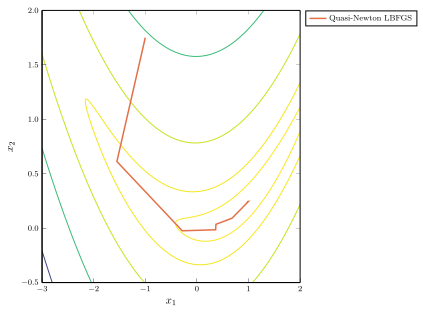

In [29]:
# save points

plot!([P[1] for P in points], [P[2] for P in points], label = "Quasi-Newton LBFGS", legend = true, lw = 1.5)

display(pl1)
savefig(pl1, "6.3c Quasi-Newton L-BFGS.svg")